In [193]:
from matplotlib import pyplot as plt 
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores

# Load results

In [246]:
out_dir = '../results/exp3'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.tail()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
0,952830aa-3dd3-4e76-96be-f8023982e469,../configs/exp3.py,8023fae5273a1fc603895e5a3a59c895,dvrl,"[0.77625, 0.79175, 0.8007500000000001, 0.81075...","[0.7717499999999999, 0.69375, 0.6905, 0.657750...",1471.007350
1,85a35d35-4d16-4219-b17a-0cd9648812c7,../configs/exp3.py,8023fae5273a1fc603895e5a3a59c895,dvrl,"[0.7557499999999999, 0.7745, 0.7795, 0.7955, 0...","[0.76125, 0.7484999999999999, 0.70625, 0.64775...",1487.605486
2,99cd03d2-3a66-4f8f-bf12-fa09e9135025,../configs/exp3.py,d99af9294e9dd7470b818233bb65ff5d,dvrl,"[0.7951666666666667, 0.8065000000000001, 0.725...","[0.7928333333333333, 0.7216666666666667, 0.648...",1287.005444
3,aadaf7cc-c683-4dbd-a8ca-de14b3029a4e,../configs/exp3.py,d99af9294e9dd7470b818233bb65ff5d,dvrl,"[0.7896666666666666, 0.7879999999999999, 0.782...","[0.7901666666666666, 0.7888333333333334, 0.796...",1437.973155


In [247]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy'), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy'),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy')
                } 
            for uid in res.uid.values}

In [248]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

WARNING! config checksums are not identical, config file may have changed between runs.


In [249]:
config = load_config(res.config.values[0])

Using cache found in /home/teddy/.cache/torch/hub/pytorch_vision_v0.10.0
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# corrupted label identification 

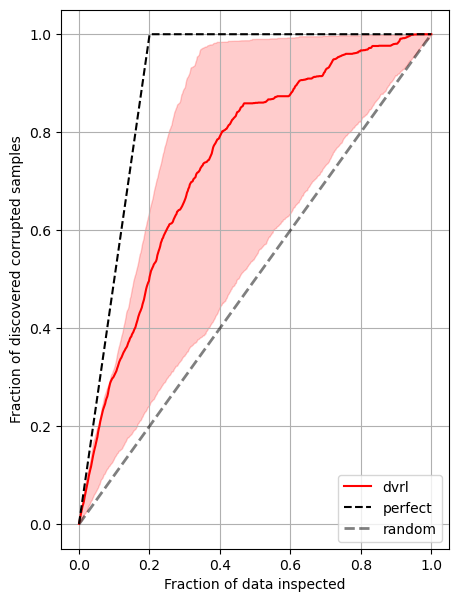

In [250]:
auroc = {m:[] for m in res.method.unique()}

plt.figure(figsize=(5, 7))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        noise_labels = vals_dict[row.uid]['endog']
        noise_idx = noise_labels.nonzero()[0]
        vals = vals_dict[row.uid]['vals']

        auroc[method].append(roc_auc_score(noise_labels, -vals))

        pk, p_corr, p_perfect, p_random = get_corruption_scores(vals, noise_idx, config.train_num, config.endog_noise)
        pp_corr.append(p_corr)

    pp_corr = np.stack(pp_corr, axis=0)

    plt.plot(pk, np.quantile(a=pp_corr, q=0.5, axis=0), color=c, label=method)
    plt.fill_between(pk, np.quantile(a=pp_corr, q=0.05, axis=0), np.quantile(a=pp_corr, q=0.95, axis=0), color=c, alpha=0.2)

plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'k--', label='random', linewidth=2, alpha=0.5)

plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(visible=None)
plt.show()

        


In [253]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in auroc: 
        table_latex.append( [f'{np.mean(auroc[method]):.3f} $\pm$ {2*np.std(auroc[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
#table_latex.style.to_latex()

In [254]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,cifar10,NA,NA,0.757 $\pm$ 0.343,NA,NA


# Filtered Data Performance

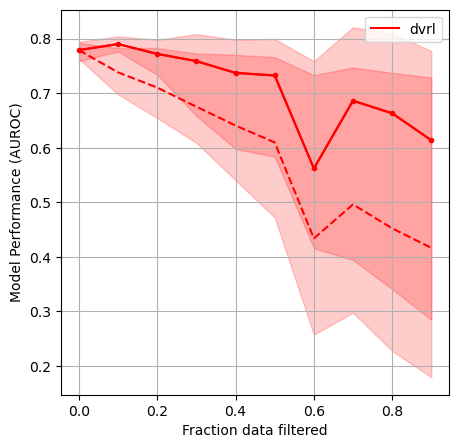

In [256]:
plt.figure(figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=method, linestyle='-')
    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, marker='.')
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_low, q=0.05, axis=0), np.quantile(a=_low, q=0.95, axis=0), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--')
    #plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, marker='.', linestyle=None)
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_high, q=0.05, axis=0), np.quantile(a=_high, q=0.95, axis=0), color=c, alpha=.2)

plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.grid(visible=None)
plt.show()